In [33]:
# Librerías para automatización de navegadores web con Selenium
from selenium import webdriver  
from webdriver_manager.chrome import ChromeDriverManager 
 
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.support.ui import Select 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException 

from time import sleep

# Librerías para captura de datos
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import pickle
import re
import json
import requests
from tqdm import tqdm

# Google sheets
import gspread
from google.auth import default
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe
from googleapiclient.discovery import build

import seaborn as sns
import matplotlib.pyplot as plt

### Conseguir URLs de Categorías

In [212]:
url = "https://minimalismbrand.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

href_links = [a["href"] for a in soup.find_all("a", class_="navigation__link") if "href" in a.attrs]

base_url = "https://minimalismbrand.com"

full_urls = []
for path in href_links:
    full_url = base_url + path
    full_urls.append(full_url)

print(full_urls)

['https://minimalismbrand.com/collections/ropa-minimalism', 'https://minimalismbrand.com/collections/ropa-minimalism-mujer', 'https://minimalismbrand.com/collections/camisetas-algodon-organico-nino-a', 'https://minimalismbrand.com/collections/mochilas', 'https://minimalismbrand.com/collections/hogar', 'https://minimalismbrand.com/pages/manifiesto-minimalism', 'https://minimalismbrand.com/collections/ropa-minimalism', 'https://minimalismbrand.com/collections/packs-minimalism', 'https://minimalismbrand.com/products/camiseta-algodon-organicox3', 'https://minimalismbrand.com/products/calzoncillos-organicos-x3-1', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/calcetines-organicos-x5-1', 'https://minimalismbrand.com/collections/hombre', 'https://minimalismbrand.com/collections/camisetas-algodon-organico', 'https://minimalismbrand.com/collections/calzoncillos', 'https://minimalismbrand.com/collections/calcetines-algodon-organi

### Conseguir URLs de Productos

In [210]:
def urls_productos(urls):
    price_pattern = re.compile(r"€\d+,\d{2}|€\d+\.\d{2}|\$\d+,\d{2}|\$\d+\.\d{2}")
    all_products_data = []
    all_product_links = [] 

    for url in urls:
        category = url.split("/")[-1]
        
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            
            product_links = [a["href"] for a in soup.find_all("a", href=True) if "product" in a["href"]]
            all_product_links.extend(product_links)

            product_sections = soup.find_all("div", class_="product-list")
            for product in product_sections:
                items = product.get_text(strip=True).split("ORGÁNICO")
                
                for item in items:
                    item = item.strip()
                    price_match = price_pattern.search(item)
                    price = price_match.group() if price_match else None
                    description = price_pattern.sub("", item).strip()
                    
                    if description and price:
                        all_products_data.append({
                            "description": description, 
                            "price": price, 
                            "url": url,
                            "category": category
                        })
        else:
            print(f"Fallo en {url}")

    #df = pd.DataFrame(all_products_data)
    base_url = "https://minimalismbrand.com"

    full_urls = []
    for path in all_product_links:
        full_url = base_url + path
        full_urls.append(full_url)
    
    return full_urls

In [213]:
links = urls_productos(full_urls)

In [215]:
print(links)

['https://minimalismbrand.com/products/camiseta-algodon-organicox3', 'https://minimalismbrand.com/products/calzoncillos-organicos-x3-1', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/calcetines-organicos-x5-1', 'https://minimalismbrand.com/products/tarjeta-regalo', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/products/culotte-minimalism-x3-1', 'https://minimalismbrand.com/products/tanga-minimalism-x3', 'https://minimalismbrand.com/products/calcetines-organicos-pinkies-x5', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/tarjeta-regalo', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/products/mochila-minimalism', 'https://minimalismbrand.com/products/mochila-minimalista', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/prod

In [216]:
# Eliminar duplicados
set_links = list(set(links))
len(set_links)

149

### Captura de Productos

In [217]:
def productos_minimalism(urls):
    todos_productos = []
    
    # Patrones tamaño, color, categoría
    size_pattern = re.compile(r"^(XS|S|M|L|XL|XXL)$")
    color_pattern = re.compile(r"^[A-Za-z\s]+$")
    category_pattern = re.compile(r"products/([^/-]+)")

    for url in tqdm(urls):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # error para status codes no válidos
            soup = BeautifulSoup(response.text, "html.parser")
            
            # nombre
            title = soup.find("h1", class_="title").get_text(strip=True) if soup.find("h1", class_="title") else None
            
            # precio
            current_price = soup.find("span", class_="current-price theme-money").get_text(strip=True) if soup.find("span", class_="current-price theme-money") else None
            
            # tallas y colores
            sizes_colors = [size.get_text(strip=True) for size in soup.find_all("span", class_="opt-label__text")]
            sizes = [item for item in sizes_colors if size_pattern.match(item)]
            colors = [item for item in sizes_colors if color_pattern.match(item) and not size_pattern.match(item)]
            
            # costes
            cost_breakdown = []
            for li in soup.find_all("li"):
                if "—" in li.get_text() and "%" in li.get_text():
                    cost_breakdown.append(li.get_text(strip=True))
            
            # producción
            production_details = []
            production_section = soup.find("div", id="block-id-template--19096866292047__2cecfbfa-137a-4ccc-97aa-6738b0cac11b-text_block-1")
            if production_section:
                production_details = [item.get_text(strip=True) for item in production_section.find_all("li")]
            
            # material, fábrica
            country_section = soup.find("div", id="block-id-template--19096866292047__2cecfbfa-137a-4ccc-97aa-6738b0cac11b-text_block-2")
            if country_section:
                text_items = [item.get_text(strip=True) for item in country_section.find_all(["p", "a"])]
                if len(text_items) > 2:
                    material = text_items[0] if country_section else None
                    factory = text_items[2] if country_section else None
            
            # categoría
            category_match = category_pattern.search(url)
            category = category_match.group(1) if category_match else None

            # valoración y cant opiniones
            opinion = soup.find("span", class_="stamped-badge-caption")
            count = opinion.get("data-reviews") if opinion else None
            rating = opinion.get("data-rating") if opinion else None
            
            todos_productos.append({
                "producto": title,
                "precio": current_price,
                "tallas": sizes,
                "colores": colors,
                "costes": cost_breakdown,
                "procedencia_algodon": production_details,
                "material": material,
                "fabrica": factory,
                "categoria": category,
                "valoracion": rating,
                "cant_valoraciones": count,
                "url": url
            })

        except requests.RequestException as e:
            print(f"Fallo en {url} por {e}")
    
    df = pd.DataFrame(todos_productos)
    df["precio"] = df["precio"].str.replace("€","").astype(float)
    df['colores'] = df['colores'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['tallas'] = df['tallas'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['costes'] = df['costes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['procedencia_algodon'] = df['procedencia_algodon'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['fabrica'] = df['fabrica'].apply(lambda x: x.split(":", 1)[1] if ":" in x else "")
    return df

In [160]:
df_minimalism = productos_minimalism(set_links)

 28%|██▊       | 41/149 [00:09<00:27,  4.00it/s]

Failed to retrieve https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism: HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x12b7219a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


 62%|██████▏   | 93/149 [00:21<00:09,  6.06it/s]

Failed to retrieve https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110832190: HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110832190 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x126f6ff70>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


 83%|████████▎ | 124/149 [00:29<00:04,  6.17it/s]

Failed to retrieve https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110799422: HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110799422 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x128b18340>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


100%|██████████| 149/149 [00:35<00:00,  4.16it/s]


In [218]:
df_minimalism = pd.read_csv("datos/minimalism_final.csv", index_col = 0)

In [219]:
df_minimalism_cat = df_minimalism.groupby("categoria")[["precio"]].mean().reset_index()

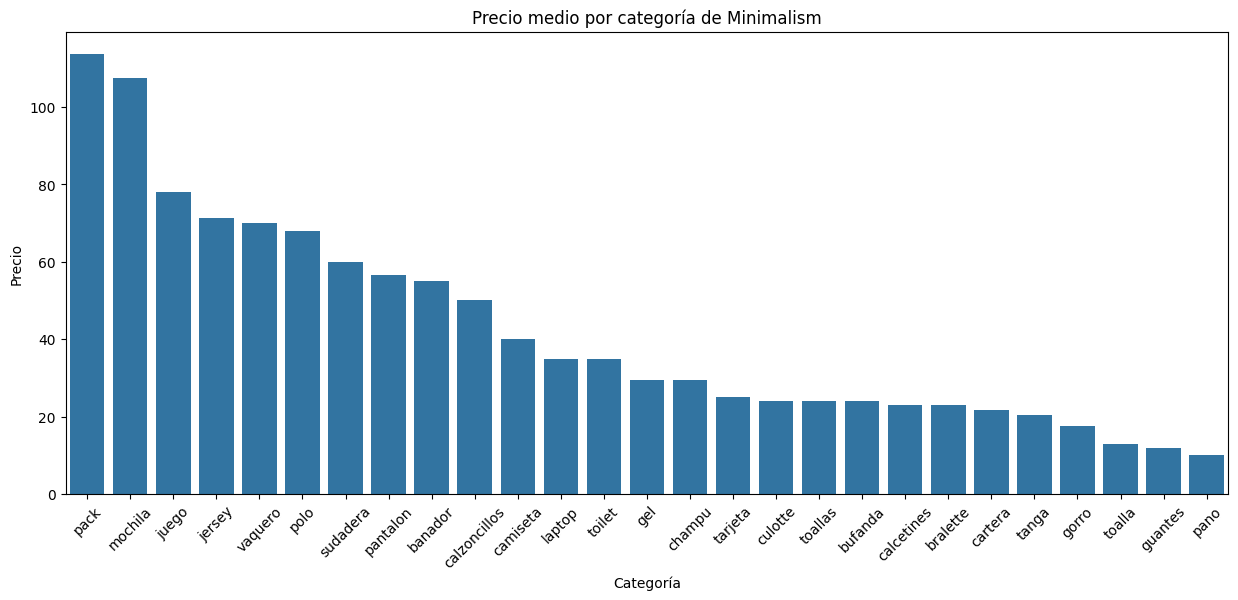

In [80]:
df_minimalism_cat_precio = df_minimalism_cat.sort_values(by="precio", ascending=False)
plt.figure(figsize=(15, 6))

sns.barplot(data=df_minimalism_cat, x="categoria", y="precio", 
            order=df_minimalism_cat_precio["categoria"])

plt.xticks(rotation=45)
plt.title("Precio medio por categoría de Minimalism")
plt.xlabel("Categoría")
plt.ylabel("Precio")

plt.show()

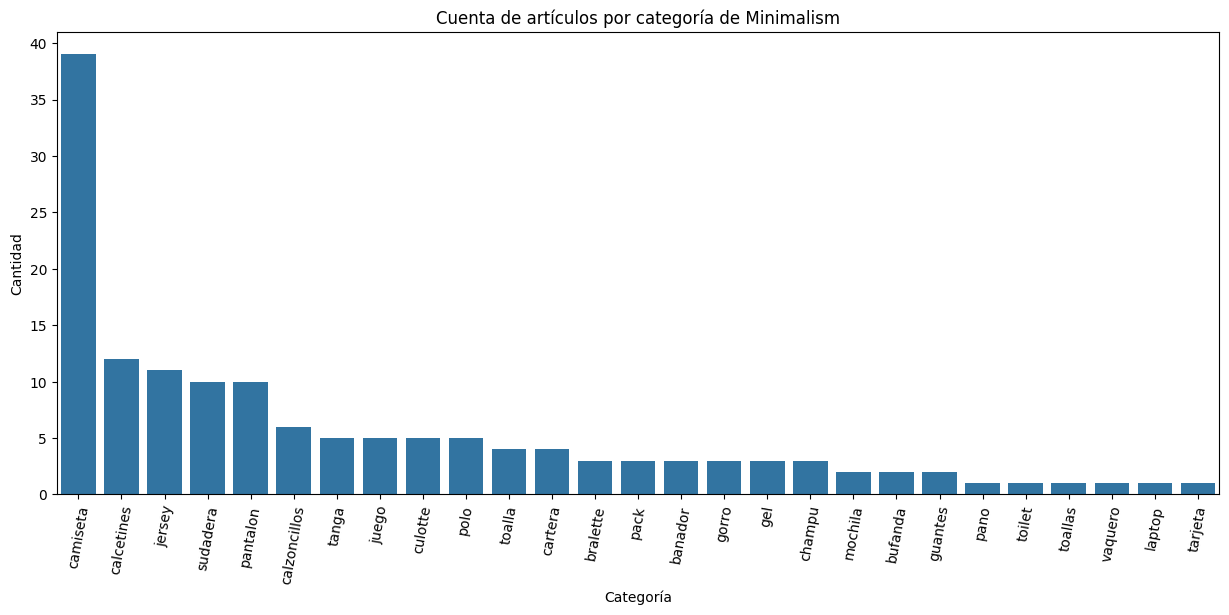

In [81]:

category_order_count = df_minimalism['categoria'].value_counts().index
plt.figure(figsize=(15, 6))

sns.countplot(data=df_minimalism, x="categoria", order=category_order_count)

plt.xticks(rotation=80)
plt.title("Cuenta de artículos por categoría de Minimalism")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")

plt.show()

In [55]:
#df_minimalism.to_csv("datos/minimalism_final.csv")

### Subimos Minimalism a Google Sheets

In [222]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

df = pd.read_csv("datos/minimalism_final.csv")

drive_service = build('drive', 'v3', credentials=creds)

# Define metadata for the new Google Sheet, including the specific folder ID
folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'  # Replace with your actual folder ID
file_metadata = {
    'name': "Minimalism",  # The name of your Google Sheet
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id]  # Specify the folder ID here
}

# Create the new Google Sheet in the specified folder
file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

# Open the newly created Google Sheet by ID
spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0)  # Access the first sheet

set_with_dataframe(worksheet, df)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets


In [67]:
df_ecoalf = pd.read_csv("datos/df_ecoalf.csv", index_col=0)

In [ ]:
df_ecoalf["precios"] = df_ecoalf["precios"].str.replace("€","")
df_ecoalf["precios"] = df_ecoalf["precios"].str.replace(",",".")
df_ecoalf["precios"] = df_ecoalf["precios"].astype(float)

In [78]:
df_ecoalf.head(3)

,nombre,precios,descripcion,genero,mateiral
0,CHAQUETA VENUE AZUL MARINO,219.9,La chaqueta Venue está hecha de poliéster reci...,hombre,Tejido principal: 100% poliéster reciclado
2,CHAQUETA GRAYS AZUL MARINO,229.9,La chaqueta Grays es monomaterial y está hecha...,hombre,Tejido principal: 100% poliéster reciclado
4,ABRIGO LIVORNO NEGRO,399.9,El abrigo Livorno está hecho con nuestro Hilo ...,hombre,Tejido principal: 100% poliéster reciclado


In [88]:
df_ecoalf_chaquetas = df_ecoalf[df_ecoalf['nombre'].str.contains("chaqueta", case=False, na=False)]
df_minimalism_jer_sud = df_minimalism[(df_minimalism["categoria"] == "jersey") | (df_minimalism["categoria"] == "sudadera")]

In [89]:
print(df_ecoalf_chaquetas["precios"].mean())
print(df_minimalism["precio"].mean())
print(df_minimalism_jer_sud["precio"].mean())

214.8190476190476
44.301095890410956
65.95238095238095


- El precio promedio de las chaquetas de ECOALF es de 214 euros.
- El precio medio de todos los productos de Minimalism es de 44 euros.
- El precio medio de los jerseys y las sudaderas de Minimalism es de 66 euros.

### Subimos Ecoalf a Google Sheets

In [221]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

drive_service = build('drive', 'v3', credentials=creds)

# Define metadata for the new Google Sheet, including the specific folder ID
folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'  # Replace with your actual folder ID
file_metadata = {
    'name': "ECOALF",  # The name of your Google Sheet
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id]  # Specify the folder ID here
}

# Create the new Google Sheet in the specified folder
file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

# Open the newly created Google Sheet by ID
spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0)  # Access the first sheet

set_with_dataframe(worksheet, df_ecoalf)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets


## Carhartt

In [204]:
with open("datos/carhartt.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

script_tag = soup.find("script", text=re.compile(r"googleImpressions.push"))

data = []

name_pattern = re.compile(r"'name':\s*\"(.*?)\"")
price_pattern = re.compile(r"parseFloat\(\"(.*?)\"")
brand_pattern = re.compile(r"'brand':\s*'(.*?)'")
category_pattern = re.compile(r"'category':\s*'(.*?)'")
list_pattern = re.compile(r"'list':\s*'(.*?)'")

if script_tag:
    products = script_tag.text.split("googleImpressions.push")

    for product in products[1:]:
        name = name_pattern.search(product)
        price = price_pattern.search(product)
        brand = brand_pattern.search(product)
        category = category_pattern.search(product)
        product_list = list_pattern.search(product)
        
        if name and price and brand and category and product_list:
            data.append({
                "producto": name.group(1),
                "precio": price.group(1).replace(",", ".").replace(".replace(/./g. '.'))",""),
                "marca": brand.group(1),
                "categoria": category.group(1),
                #"lista": product_list.group(1)
            })

df_carhartt = pd.DataFrame(data)

df_carhartt[['producto', 'color']] = df_carhartt['producto'].str.split(' / ', expand=True)
df_carhartt['categoria'] = df_carhartt['categoria'].replace({
    "men-jackets-winter": "abrigo",
    "men-jackets-vests": "chaleco",
    "men-jackets-parka": "parka",
    "men-jackets-outdoor": "abrigo",
    "men-jackets-coats": "chaqueta",
    "men-jackets-shirt": "chaqueta",
    "men-jackets-work": "chaqueta",
    "men-jackets-fleece": "forro polar",
    "men-jackets-lightweight":"chaqueta"
})
df_carhartt = df_carhartt[["marca", "categoria", "producto", "color", "precio"]]

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_73269/3073602502.py:4: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find("script", text=re.compile(r"googleImpressions.push"))


In [205]:
df_carhartt["categoria"].unique()

array(['abrigo', 'chaleco', 'parka', 'chaqueta', 'forro polar'],
      dtype=object)

In [207]:
df_carhartt.head(5)

,marca,categoria,producto,color,precio
0,Carhartt,abrigo,Springfield Vest Peanut,Chocolate,179.00
1,Carhartt,chaleco,Rayley Vest Peanut,None,199.00
2,Carhartt,chaleco,Rayley Vest Black,None,199.00
3,Carhartt,abrigo,"Springfield Vest Camo Duck, Grey",Hamilton Brown,199.00
4,Carhartt,parka,Hooded Olten Parka Duck Green,None,299.00


In [208]:
df_carhartt_chaq = df_carhartt[df_carhartt["categoria"] == "chaqueta"]
df_carhartt_chaq["precio"] = df_carhartt_chaq["precio"].astype(float)
df_carhartt_chaq["precio"].mean()

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_73269/4121165494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carhartt_chaq["precio"] = df_carhartt_chaq["precio"].astype(float)


np.float64(214.45454545454547)

El precio medio de las chaquetas en Carhartt es de 214 euros.

In [209]:
df_carhartt_detroit = df_carhartt[df_carhartt['producto'].str.contains("detroit", case=False, na=False)]
df_carhartt_detroit["precio"] = df_carhartt_detroit["precio"].astype(float)
df_carhartt_detroit["precio"].mean()

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_73269/3567525159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carhartt_detroit["precio"] = df_carhartt_detroit["precio"].astype(float)


np.float64(214.0)

### Subimos Carhartt a Google Sheets

In [224]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

drive_service = build('drive', 'v3', credentials=creds)

# Define metadata for the new Google Sheet, including the specific folder ID
folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'  # Replace with your actual folder ID
file_metadata = {
    'name': "Carhartt",  # The name of your Google Sheet
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id]  # Specify the folder ID here
}

# Create the new Google Sheet in the specified folder
file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

# Open the newly created Google Sheet by ID
spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0)  # Access the first sheet

set_with_dataframe(worksheet, df_carhartt)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets
